In [1]:
import numpy as np
import importlib
import matplotlib.cm as cm
import time
from IPython.display import Video

import ca_environment as caenv
import ca_agent as caag

import neat
import neat_stuff.visualize as visualize
import os

In [2]:
importlib.reload(caenv)
importlib.reload(caag)
importlib.reload(visualize)

<module 'neat_stuff.visualize' from '/Users/aidanbarbieux/CSC/580-CSC/WIDDAK/nca/neat_stuff/visualize.py'>

In [3]:
def random_walk(chunk, foveal, env):
    out = (np.random.random(2))*2-1
    out = np.append(out,foveal,axis=0)
    out = np.append(out,np.zeros((env.n_hidden))+1, axis=0)
    return out

ENVIRONMENT: walk_test_eg
CAAgent ID: Random walker
	KERNEL: moore
	AGENT_TYPE: foveal_walk
		FOVEAL_CHs: 4
		SPATIAL_CHs: 3


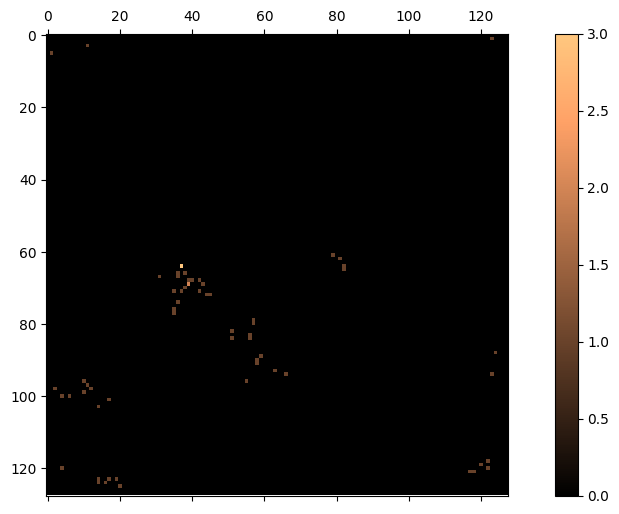

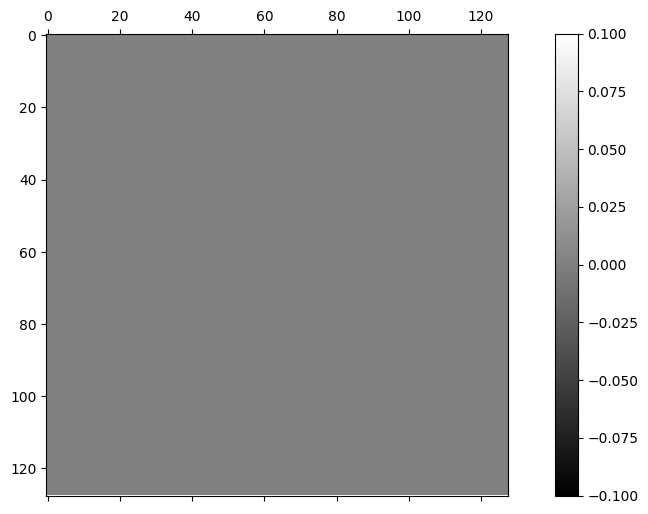

In [6]:
importlib.reload(caag)
importlib.reload(caenv)
wenv = caenv.CAEnvironment("walk_test_eg")
w_ragent = caag.CAAgent("Random walker",kernel="moore")
w_ragent.set_walk_func(random_walk)
wenv.update_shape((w_ragent.n_spatial_chs + 1, 128, 128), n_hidden_chs=w_ragent.n_spatial_chs)

wenv.food_amt = 64
wenv.beta = 1
wenv.alpha = 0.7
wenv.gen_padded_food()
wenv.display()
print(w_ragent.display())

In [ ]:
f = w_ragent.apply_walk_to_env(wenv, max_steps=1000)
wenv.display(channels=(0,3))
f


In [ ]:
def fitness_function(net, env=None, max_steps=1000, log=False, vid_speed=10):
   # env = caenv.CAEnvironment()
   # env.update_shape((3 + 1, 128, 128), n_hidden_chs=3)
   # chs = np.loadtxt(f"./test_envs/{int((time.time()*2)%100)}.txt", dtype = float)
   # env.channels = chs.reshape(env.eshape)

   agent = caag.CAAgent(kernel = "von_n")
   
   def walk_func(chunk, foveal, env):
      return net.activate(np.append(chunk.flatten(), foveal.flatten()))

   agent.set_walk_func(walk_func)
   agent.foveal_size = 4
   agent.n_spatial_chs = 3
   out =  agent.apply_walk_to_env(env, max_steps=1000, log=log, vid_speed=vid_speed)
   return out

In [ ]:
np.savetxt("./neat_stuff/curr_env.txt", [0], fmt='%d')

In [ ]:
def eval_genomes(genomes, config):
    env = caenv.CAEnvironment()
    env.update_shape((3 + 1, 128, 128), n_hidden_chs=3)
    curr_env = np.loadtxt("./neat_stuff/curr_env.txt", dtype=float)
    curr_env = (curr_env + 1/3) % 10
    np.savetxt("./neat_stuff/curr_env.txt", [curr_env], fmt='%f')
    chs = np.loadtxt(f"./walk_test_envs/{int(curr_env)}.txt", dtype = float)
    # print(f"./walk_test_envs/{int(curr_env)}.txt")
    for genome_id, genome in genomes:
        env.channels = np.copy(chs.reshape(env.eshape))
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        genome.fitness = fitness_function(net, env=env)

In [ ]:
config_file = './neat_stuff/neat.config'

# Load configuration.
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                        neat.DefaultSpeciesSet, neat.DefaultStagnation,
                        config_file)

# Create the population, which is the top-level object for a NEAT run.
p = neat.Population(config)

# Add a stdout reporter to show progress in the terminal.
p.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
p.add_reporter(stats)
# p.add_reporter(neat.Checkpointer(5))

In [ ]:
# Run for up to 300 generations.
winner = p.run(eval_genomes, 300)

In [ ]:
# Display the winning genome.
print('\nBest genome:\n{!s}'.format(winner))

# Show output of the most fit genome against training data.
print('\nOutput:')
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
# for xi, xo in zip(xor_inputs, xor_outputs):
#     output = winner_net.activate(xi)
#     print("input {!r}, expected output {!r}, got {!r}".format(
#         xi, xo, output))

# node_names = {-1: 'A', -2: 'B', 0: 'A XOR B'}
visualize.draw_net(config, winner, True)#, node_names=node_names)
# visualize.draw_net(config, winner, True,
#                    node_names=node_names, prune_unused=True)
visualize.plot_stats(stats, ylog=False, view=True)
visualize.plot_species(stats, view=True)

# p = neat.Checkpointer.restore_checkpoint('neat-checkpoint-4')
# p.run(eval_genomes, 10)

In [ ]:
env = caenv.CAEnvironment()
env.update_shape((3 + 1, 128, 128), n_hidden_chs=3)
curr_env = np.loadtxt("./neat_stuff/curr_env.txt", dtype=float)
# curr_env = (curr_env + 1/3) % 10
# np.savetxt("./neat_stuff/curr_env.txt", [curr_env], fmt='%f')
chs = np.loadtxt(f"./walk_test_envs/{int(curr_env)}.txt", dtype = float)
env.channels = np.copy(chs.reshape(env.eshape))
env.display(channels=[0])

In [ ]:
importlib.reload(caag)
f,hist = fitness_function(winner_net, env, max_steps = 100, log=True, vid_speed=2)
f

In [ ]:
Video(env.gen_video())

In [ ]:
import pandas as pd

df = pd.DataFrame(hist, columns=["x","y"])


In [ ]:
df['x1'] = df.x.shift(1)
df['y1'] = df.y.shift(1)


In [ ]:
dists = np.linalg.norm(df[['x1','y1']][1:].values - df[['x','y']][1:].values, axis=1)

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(figsize=(12, 4))
df['d']=np.append([0],dists)
df['d'].plot(kind='density', ax=axs)
plt.xlabel("step dist")
plt.xlim((-10,128))

In [ ]:
env.display(channels=[0,1,2], cmaps = [cm.copper,cm.gray,cm.hot])